In [7]:
import torch
import torch.nn as nn
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 32
BATCH_SIZE = 16
x_dim = 2
y_dim = 3
input_dim = x_dim + y_dim
hidden_dim = 128
z_dim = 128
print(f"Using Device: {DEVICE}")
class neural_process(nn.Module):
    def __init__(self):
        super(neural_process, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU()
        )
        self.encoder_mu = nn.Linear(hidden_dim, z_dim)
        self.encoder_logvar = nn.Linear(hidden_dim, z_dim)
        self.decoder = nn.Sequential(
            nn.Linear(x_dim + z_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, y_dim),
            nn.Sigmoid()
        )

    def reparameterise(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        epsilon = torch.randn_like(std)
        z = mu + std * epsilon
        return z

    def aggregate(self, r_i):
        return torch.mean(r_i, dim=1)

    def forward(self, x_c, y_c, x_t):
        #x_c=(M, N_c, x_dim), y_c = (M, N_c, y_dim)
        input = torch.cat((x_c, y_c), dim=-1)
        #r_i=(M, N, 128)
        r_i = self.encoder(input)
        #r = (M,128)
        r = self.aggregate(r_i)
        mu = self.encoder_mu(r)
        logvar = self.encoder_logvar(r)
        z = self.reparameterise(mu, logvar)
        #x_t=(M,N_t,x_dim)
        z_expanded = z.unsqueeze(1).expand(-1, x_t.size(1), -1)
        decoder_input = torch.cat((x_t, z_expanded), dim=-1)
        output = self.decoder(decoder_input)
        return output, mu, logvar
model = neural_process().to(DEVICE)
print(model)

Using Device: cuda
neural_process(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (encoder_mu): Linear(in_features=128, out_features=128, bias=True)
  (encoder_logvar): Linear(in_features=128, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=130, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=3, bias=True)
    (7): Sigmoid()
  )
)


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [9]:
def loss_function(output, y_t, mu_c, logvar_c, mu_t, logvar_t):
    diff = y_t - output
    diff_sq = torch.pow(diff, 2)
    rst_error = torch.sum(diff_sq) / BATCH_SIZE
    KL = 0.5 * (logvar_c- logvar_t + torch.exp(logvar_t - logvar_c) + (mu_c - mu_t)**2 * torch.exp(-logvar_c) - 1)

    return rst_error + 0.5*torch.sum(KL) / BATCH_SIZE

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Dataset Loaded. Total images: 162770

--- 데이터 로더 테스트 ---
Original Image Shape: torch.Size([16, 3, 32, 32])
NP Input x (Coordinates): torch.Size([16, 1024, 2])
NP Input y (Pixel Values): torch.Size([16, 1024, 3])


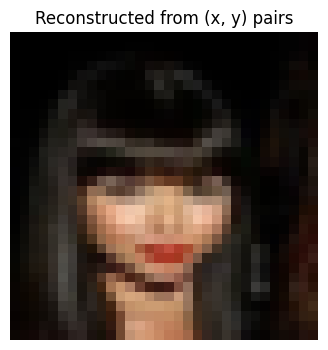

In [10]:
# --- 1. Dataset & DataLoader 정의 ---
DATA_PATH = './data'

# [FIX] 데이터셋 무결성 검사 우회 (수동 준비된 데이터셋 사용 시 필요)
datasets.CelebA._check_integrity = lambda self: True

# 이미지 전처리: 리사이즈 및 텐서 변환
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE)), # 얼굴 중심 자르기
    transforms.ToTensor(), # 0~1 사이 값으로 변환
])

# CelebA 데이터셋 로드
# download=False로 설정 (위에서 직접 받았으므로)
try:
    train_dataset = datasets.CelebA(
        root=DATA_PATH,
        split='train',
        target_type='attr',
        transform=transform,
        download=False
    )
    print(f"Dataset Loaded. Total images: {len(train_dataset)}")
except RuntimeError as e:
    print("데이터 경로 오류! 1단계의 폴더 정리가 제대로 되었는지 확인해주세요.")
    raise e

# 데이터 로더 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=2
)

# --- 2. 이미지 -> (x, y) 좌표 변환 함수 (핵심) ---

def image_to_np_input(images):
    """
    이미지 배치를 뉴럴 프로세스 입력 형태인 (좌표, 픽셀값)으로 변환
    Args:
        images: (Batch, C, H, W) 형태의 이미지 텐서
    Returns:
        x: (Batch, N_points, 2) -> 정규화된 좌표 (-1 ~ 1)
        y: (Batch, N_points, C) -> 픽셀 값 (R, G, B)
    """
    batch_size, c, h, w = images.shape

    # 1. 좌표 그리드 생성 (x)
    # -1 ~ 1 사이로 정규화된 좌표 생성
    rows = torch.linspace(-1, 1, h, device=images.device)
    cols = torch.linspace(-1, 1, w, device=images.device)

    # (H, W) 그리드 생성
    grid_rows, grid_cols = torch.meshgrid(rows, cols, indexing='ij')

    # (H, W, 2) 형태로 결합
    grid = torch.stack([grid_rows, grid_cols], dim=-1)

    # 배치 크기만큼 복사하고 평탄화 (Batch, H*W, 2)
    x = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1).reshape(batch_size, -1, 2)

    # 2. 픽셀 값 평탄화 (y)
    # (Batch, C, H, W) -> (Batch, H, W, C) -> (Batch, H*W, C)
    y = images.permute(0, 2, 3, 1).reshape(batch_size, -1, c)

    return x, y

# --- 3. 사용 예시 (Training Loop 시뮬레이션) ---

print("\n--- 데이터 로더 테스트 ---")

# 데이터 로더에서 배치 하나 가져오기
# images: (16, 3, 32, 32), attributes: (16, 40)
images, _ = next(iter(train_loader))
images = images.to(DEVICE)

# 뉴럴 프로세스 포맷으로 변환
batch_x, batch_y = image_to_np_input(images)

print(f"Original Image Shape: {images.shape}") # [16, 3, 32, 32]
print(f"NP Input x (Coordinates): {batch_x.shape}") # [16, 1024, 2] -> (x, y) 좌표
print(f"NP Input y (Pixel Values): {batch_y.shape}") # [16, 1024, 3] -> (R, G, B)

# --- 4. 시각화 확인 (좌표계가 이미지를 잘 표현하는지 역변환) ---
# 첫 번째 배치의 이미지를 복원해봅니다.
reconstructed_img = batch_y[0].reshape(IMG_SIZE, IMG_SIZE, 3).cpu()

plt.figure(figsize=(4, 4))
plt.imshow(reconstructed_img)
plt.title("Reconstructed from (x, y) pairs")
plt.axis('off')
plt.show()

In [11]:
# batch_x: (Batch, N, x_dim)
# batch_y: (Batch, N, y_dim)

# 1. Context와 Target 분할 (앞서 설명한 방식대로)
# 예: 총 50개 점 중, 10개를 Context, 50개 전체를 Target으로 사용
import random
CONTEXT = 10
def train(model, optimizer, batch_x, batch_y):
    optimizer.zero_grad()
    num_points = batch_x.size(1)
    num_c = random.randint(num_points // 3, num_points - CONTEXT)
    x_c = batch_x[:, :num_c, :]
    y_c = batch_y[:, :num_c, :]
    x_t = batch_x # 전체
    y_t = batch_y # 전체

    input_t = torch.cat([x_t, y_t], dim=-1)
    r_i_t = model.encoder(input_t)
    r_t = model.aggregate(r_i_t)
    mu_t = model.encoder_mu(r_t)
    logvar_t = model.encoder_logvar(r_t)

    output, mu_c, logvar_c = model(x_c, y_c, x_t)

    # Loss
    loss = loss_function(output, y_t, mu_c, logvar_c, mu_t, logvar_t)

    loss.backward()
    optimizer.step()
    return loss

In [12]:

model.train()
EPOCHS = 30
for epoch in range(EPOCHS):
    total_loss = 0
    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)
        batch_x, batch_y = image_to_np_input(images)
        loss = train(model, optimizer, batch_x, batch_y)
        total_loss += loss.item()
    print(f"Epoch[{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")
print("학습완료")

Epoch[1/30], Loss: 175.6782
Epoch[2/30], Loss: 126.3938
Epoch[3/30], Loss: 116.0456
Epoch[4/30], Loss: 112.4895
Epoch[5/30], Loss: 108.7963
Epoch[6/30], Loss: 105.3542
Epoch[7/30], Loss: 102.4069
Epoch[8/30], Loss: 100.7510
Epoch[9/30], Loss: 98.8042
Epoch[10/30], Loss: 97.2744
Epoch[11/30], Loss: 96.0489
Epoch[12/30], Loss: 95.1735
Epoch[13/30], Loss: 94.2857
Epoch[14/30], Loss: 93.3276
Epoch[15/30], Loss: 92.7424
Epoch[16/30], Loss: 91.9683
Epoch[17/30], Loss: 91.0864
Epoch[18/30], Loss: 90.5622
Epoch[19/30], Loss: 90.0721
Epoch[20/30], Loss: 89.7509
Epoch[21/30], Loss: 89.4420
Epoch[22/30], Loss: 89.0084
Epoch[23/30], Loss: 88.9140
Epoch[24/30], Loss: 88.2963
Epoch[25/30], Loss: 87.9295
Epoch[26/30], Loss: 87.9346
Epoch[27/30], Loss: 87.4633
Epoch[28/30], Loss: 86.8977
Epoch[29/30], Loss: 86.6947
Epoch[30/30], Loss: 86.6105
학습완료


--- Inpainting Visualization (Total Points: 1024) ---


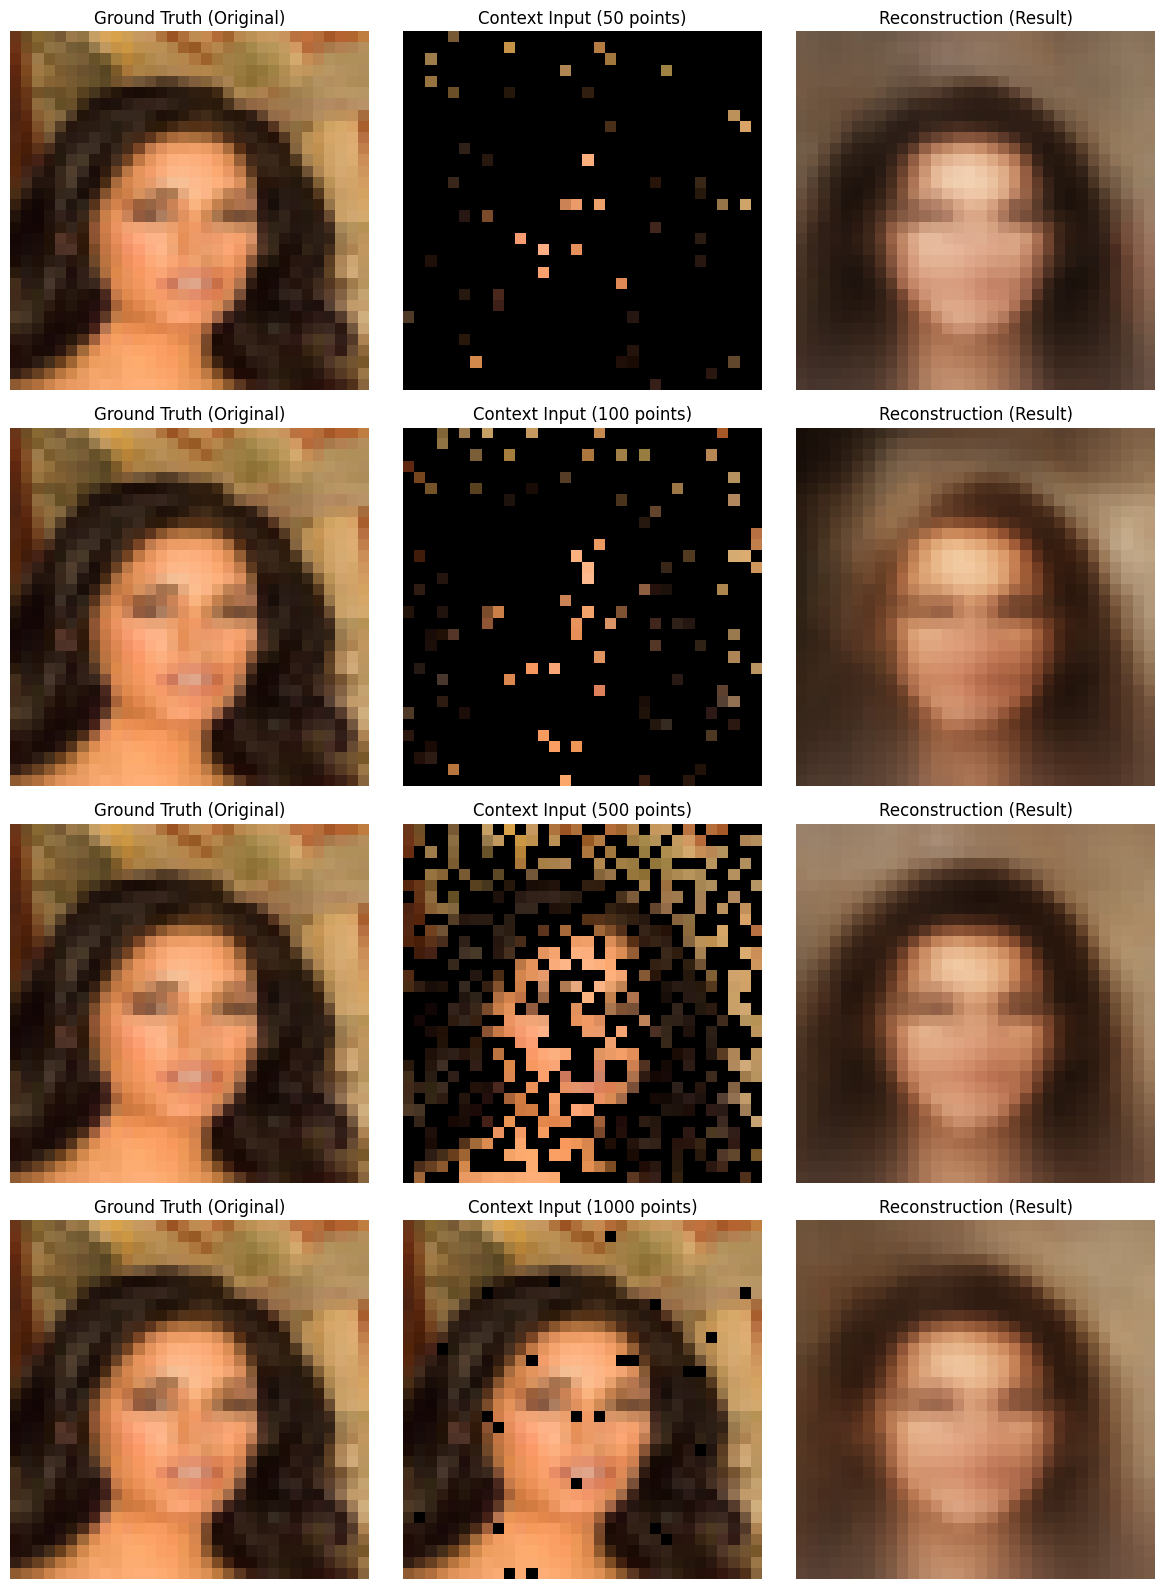

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_inpainting_process(model, test_loader, context_counts=[10, 100, 500, 1000]):
    """
    context_counts 리스트에 있는 개수만큼 점을 늘려가며 복원 과정을 시각화합니다.
    """
    model.eval()

    # 1. 테스트 이미지 하나 고정 (동일한 이미지로 비교하기 위해 루프 밖에서 로드)
    images, _ = next(iter(test_loader))
    test_img = images[0].unsqueeze(0).to(DEVICE) # (1, 3, 32, 32)

    # 좌표 변환
    batch_x, batch_y = image_to_np_input(test_img)
    num_points = batch_x.size(1) # 1024 (32x32)

    # 2. 시각화 캔버스 설정 (행: 단계 수, 열: 3개 [원본, 입력, 출력])
    fig, axes = plt.subplots(len(context_counts), 3, figsize=(12, 4 * len(context_counts)))

    # 원본 이미지 준비 (모든 단계에서 동일)
    ground_truth = batch_y.reshape(IMG_SIZE, IMG_SIZE, 3).cpu().detach().numpy()

    print(f"--- Inpainting Visualization (Total Points: {num_points}) ---")

    for i, num_context in enumerate(context_counts):
        with torch.no_grad():
            # (1) Context 랜덤 선택
            indices = torch.randperm(num_points)
            context_idx = indices[:num_context]

            x_c = batch_x[:, context_idx, :]
            y_c = batch_y[:, context_idx, :]
            x_t = batch_x # Target은 전체

            # (2) 모델 추론
            y_pred, _, _ = model(x_c, y_c, x_t)

            # (3) 시각화용 이미지 생성

            # A. Context View (검은 배경에 힌트 점만 찍기)
            context_img = torch.zeros_like(batch_y) # 검은색 바탕
            context_img[:, context_idx, :] = y_c    # 해당 위치만 색칠
            context_img = context_img.reshape(IMG_SIZE, IMG_SIZE, 3).cpu().numpy()

            # B. Prediction View (복원 결과)
            pred_img = y_pred.reshape(IMG_SIZE, IMG_SIZE, 3).cpu().numpy()
            pred_img = np.clip(pred_img, 0, 1) # 0~1 범위로 맞춤

            # (4) 서브플롯 그리기
            # 만약 리스트가 1개뿐이라면 axes가 1차원 배열이 되므로 처리 필요
            ax_row = axes[i] if len(context_counts) > 1 else axes

            # 첫 번째 열: Ground Truth (비교를 위해 매번 출력)
            ax_row[0].imshow(ground_truth)
            ax_row[0].set_title("Ground Truth (Original)")
            ax_row[0].axis('off')

            # 두 번째 열: Context Input (모델이 본 것)
            ax_row[1].imshow(context_img)
            ax_row[1].set_title(f"Context Input ({num_context} points)")
            ax_row[1].axis('off')

            # 세 번째 열: Reconstructed Output (모델이 상상한 것)
            ax_row[2].imshow(pred_img)
            ax_row[2].set_title(f"Reconstruction (Result)")
            ax_row[2].axis('off')

    plt.tight_layout()
    plt.show()

# --- 실행 ---
# 리스트를 직접 수정해서 원하는 단계 조절 가능
visualize_inpainting_process(model, train_loader, context_counts=[50, 100, 500, 1000])

In [15]:
model.train()
EPOCHS = 10
for epoch in range(EPOCHS):
    total_loss = 0
    for data in train_loader:
        images, _ = data
        images = images.to(DEVICE)
        batch_x, batch_y = image_to_np_input(images)
        loss = train(model, optimizer, batch_x, batch_y)
        total_loss += loss.item()
    print(f"Epoch[{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")
print("학습완료")

Epoch[1/10], Loss: 86.3037
Epoch[2/10], Loss: 86.4268
Epoch[3/10], Loss: 86.0429
Epoch[4/10], Loss: 85.7995
Epoch[5/10], Loss: 85.6624
Epoch[6/10], Loss: 85.5214
Epoch[7/10], Loss: 85.2185
Epoch[8/10], Loss: 85.2964
Epoch[9/10], Loss: 85.0377
Epoch[10/10], Loss: 84.7264
학습완료


--- Inpainting Visualization (Total Points: 1024) ---


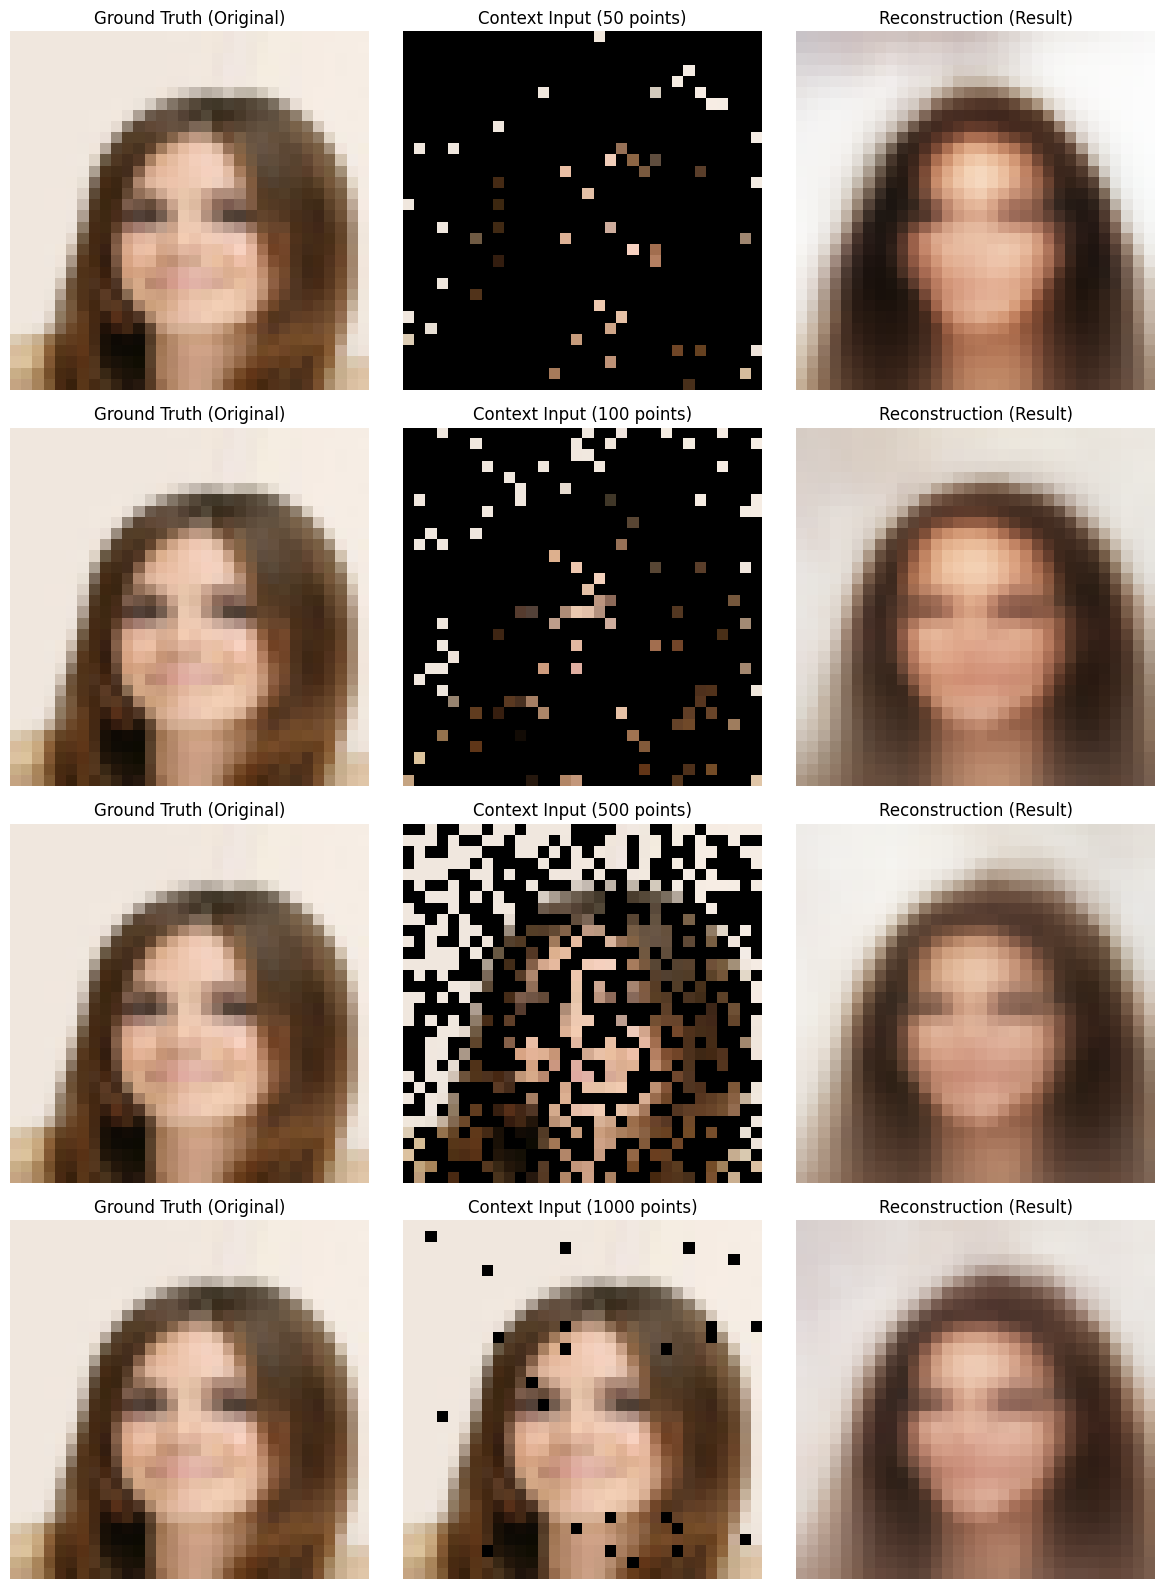

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_inpainting_process(model, test_loader, context_counts=[10, 100, 500, 1000]):
    """
    context_counts 리스트에 있는 개수만큼 점을 늘려가며 복원 과정을 시각화합니다.
    """
    model.eval()

    # 1. 테스트 이미지 하나 고정 (동일한 이미지로 비교하기 위해 루프 밖에서 로드)
    images, _ = next(iter(test_loader))
    test_img = images[0].unsqueeze(0).to(DEVICE) # (1, 3, 32, 32)

    # 좌표 변환
    batch_x, batch_y = image_to_np_input(test_img)
    num_points = batch_x.size(1) # 1024 (32x32)

    # 2. 시각화 캔버스 설정 (행: 단계 수, 열: 3개 [원본, 입력, 출력])
    fig, axes = plt.subplots(len(context_counts), 3, figsize=(12, 4 * len(context_counts)))

    # 원본 이미지 준비 (모든 단계에서 동일)
    ground_truth = batch_y.reshape(IMG_SIZE, IMG_SIZE, 3).cpu().detach().numpy()

    print(f"--- Inpainting Visualization (Total Points: {num_points}) ---")

    for i, num_context in enumerate(context_counts):
        with torch.no_grad():
            # (1) Context 랜덤 선택
            indices = torch.randperm(num_points)
            context_idx = indices[:num_context]

            x_c = batch_x[:, context_idx, :]
            y_c = batch_y[:, context_idx, :]
            x_t = batch_x # Target은 전체

            # (2) 모델 추론
            y_pred, _, _ = model(x_c, y_c, x_t)

            # (3) 시각화용 이미지 생성

            # A. Context View (검은 배경에 힌트 점만 찍기)
            context_img = torch.zeros_like(batch_y) # 검은색 바탕
            context_img[:, context_idx, :] = y_c    # 해당 위치만 색칠
            context_img = context_img.reshape(IMG_SIZE, IMG_SIZE, 3).cpu().numpy()

            # B. Prediction View (복원 결과)
            pred_img = y_pred.reshape(IMG_SIZE, IMG_SIZE, 3).cpu().numpy()
            pred_img = np.clip(pred_img, 0, 1) # 0~1 범위로 맞춤

            # (4) 서브플롯 그리기
            # 만약 리스트가 1개뿐이라면 axes가 1차원 배열이 되므로 처리 필요
            ax_row = axes[i] if len(context_counts) > 1 else axes

            # 첫 번째 열: Ground Truth (비교를 위해 매번 출력)
            ax_row[0].imshow(ground_truth)
            ax_row[0].set_title("Ground Truth (Original)")
            ax_row[0].axis('off')

            # 두 번째 열: Context Input (모델이 본 것)
            ax_row[1].imshow(context_img)
            ax_row[1].set_title(f"Context Input ({num_context} points)")
            ax_row[1].axis('off')

            # 세 번째 열: Reconstructed Output (모델이 상상한 것)
            ax_row[2].imshow(pred_img)
            ax_row[2].set_title(f"Reconstruction (Result)")
            ax_row[2].axis('off')

    plt.tight_layout()
    plt.show()

# --- 실행 ---
# 리스트를 직접 수정해서 원하는 단계 조절 가능
visualize_inpainting_process(model, train_loader, context_counts=[50, 100, 500, 1000])